https://arxiv.org/pdf/1611.00054.pdf

First, use tratidional numerical method for dynamics simulation (like ode45 in matlab)

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

start simulation
elapsed time: 1.10783815384 sec


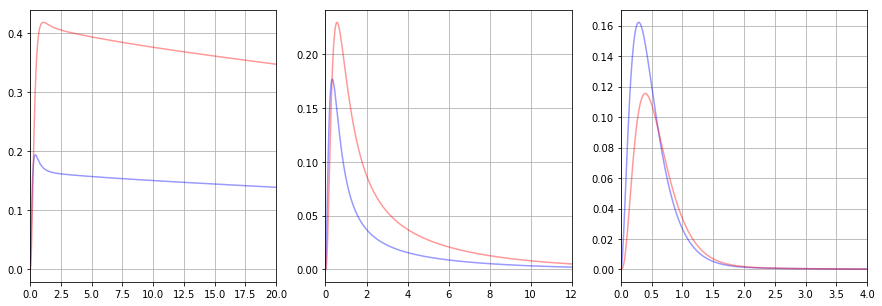

In [14]:
M = 1;    d = 1
k0 = 5/d;    k1 = 10/d;    k2 = 10/d;    k3 = 5/(M*d);    k4 = 0.00001/d;    k7 = 0.01/d;     k8 = 0.5/(M*d);
k_7 = 1/(M*d);    k_1 = 0.01/d;    k_2 = 4/d;    k_3 = 0.01/(M*M*d);    k_4 = 0.1/d;    k_8 = 0.01/d;
VPUR = 0.01/d
VD = 0.9/d
VOUT = 0.0001/d


def metabolic_6MP(t, state):
    MPex   = state[0] 
    MPin   = state[1]
    TIMP   = state[2]
    TXMP   = state[3]
    TGMP   = state[4]
    meTGMP = state[5]
    TITP   = state[6]
    ATP    = state[7]
    AMP    = state[8]
    PP     = state[9]
    
    dMPex_dt   = -k0*MPex
    dMPin_dt   = -(VPUR + k1)*MPin + k0*MPex + k_1*TIMP
    dTIMP_dt   = k1*MPin + k_8*TITP - (k2 + k7*ATP + k_1 + k8*PP)*TIMP + k_2*TXMP + k_7*TITP*AMP
    dTXMP_dt   = k2*TIMP - k3*TXMP*ATP - k_2*TXMP + k_3*TGMP*AMP*PP
    dTGMP_dt   = k3*TXMP*ATP - (k4 + VD)*TGMP - k_3*TGMP*AMP*PP + k_4*meTGMP
    dmeTGMP_dt = k4*TGMP - VOUT*meTGMP - k_4*meTGMP
    dTITP_dt   = k8*TIMP*PP - k_8*TITP + k7*TIMP*ATP - k_7*TITP*AMP
    dATP_dt    = -k7*TIMP*ATP + k_3*TGMP*AMP*PP - k3*TXMP*ATP + k_7*TITP*AMP
    dAMP_dt    = -k_3*TGMP*AMP*PP + k3*TXMP*ATP + k7*TIMP*ATP - k_7*TITP*AMP
    dPP_dt     = -k8*TIMP*PP + k_8*TITP - k_3*TGMP*AMP*PP + k3*TXMP*ATP

    return np.array([dMPex_dt, dMPin_dt, dTIMP_dt, dTXMP_dt, dTGMP_dt, dmeTGMP_dt, dTITP_dt, dATP_dt, dAMP_dt, dPP_dt])
   
X0 = np.array([[0.68, 0, 0, 0, 0, 0, 0, 0.1, 0, 0], # MPex(0) = 0.68, ATP(0) = 0.1
               [0.68, 0, 0, 0, 0, 0, 0, 0.7, 0, 0], # MPex(0) = 0.68, ATP(0) = 0.7
               [0.68, 0, 0, 0, 0, 0, 0, 2, 0, 0]])# MPex(0) = 0.68, ATP(0) = 2

t = 20

fig, ax = plt.subplots(1, 3, sharey=False) 
fig.set_size_inches(15, 5)

import time
print('start simulation')
start = time.time()
X_res = []
for i, state0 in enumerate(X0):
    X_res.append(solve_ivp(metabolic_6MP, [0, t], state0, max_step=0.01))

print('elapsed time: %s sec'% (time.time()-start))

for i, X in enumerate(X_res):
    ax[i].plot(X.t, X.y[2, :], 'b-', alpha = 0.4) # TIMP
    ax[i].plot(X.t, X.y[3, :], 'r-', alpha = 0.4) # TXMP
#     ax[i].plot(X.t, X.y[6, :], 'g-', alpha = 0.4) # TITP
    ax[i].grid()

ax[0].set_xlim([0, 20])
ax[1].set_xlim([0, 12])
ax[2].set_xlim([0, 4])

plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')

from core.Lie import LieLayer
from core.Lie_map_builder import LieMapBuilder

from sympy import Symbol

Using TensorFlow backend.


At the begining let's define a system of ordinary differential equations that describe or RKIP dynamics ([see article](https://www.researchgate.net/publication/299157975_From_Petri_nets_to_differential_equations_-_An_integrative_approach_for_biochemical_network_analysis)).

In [4]:
m1 = Symbol('m01');    m2 = Symbol('m02');    m3 = Symbol('m03');    m4 = Symbol('m04')
m5 = Symbol('m05');    m6 = Symbol('m06');    m7 = Symbol('m07');    m8 = Symbol('m08')
m9 = Symbol('m09');    m10 = Symbol('m10');   m11 = Symbol('m11')

MPex   = Symbol('MPex')
MPin   = Symbol('MPin')
TIMP   = Symbol('TIMP')
TXMP   = Symbol('TXMP')
TGMP   = Symbol('TGMP')
meTGMP = Symbol('meTGMP')
TITP   = Symbol('TITP')
ATP    = Symbol('ATP')
AMP    = Symbol('AMP')
PP     = Symbol('PP')

dMPex_dt   = -k0*MPex
dMPin_dt   = -VPUR*MPin - k1*MPin + k0*MPex + k_1*TIMP
dTIMP_dt   = k1*MPin + k_8*TITP -k2*TIMP - k7*ATP*TIMP - k_1*TIMP - k8*PP*TIMP + k_2*TXMP + k_7*TITP*AMP
dTXMP_dt   = k2*TIMP - k3*TXMP*ATP - k_2*TXMP + k_3*TGMP*AMP*PP
dTGMP_dt   = k3*TXMP*ATP -k4*TGMP - VD*TGMP - k_3*TGMP*AMP*PP + k_4*meTGMP
dmeTGMP_dt = k4*TGMP - VOUT*meTGMP - k_4*meTGMP
dTITP_dt   = k8*TIMP*PP - k_8*TITP + k7*TIMP*ATP - k_7*TITP*AMP
dATP_dt    = -k7*TIMP*ATP + k_3*TGMP*AMP*PP - k3*TXMP*ATP + k_7*TITP*AMP
dAMP_dt    = -k_3*TGMP*AMP*PP + k3*TXMP*ATP + k7*TIMP*ATP - k_7*TITP*AMP
dPP_dt     = -k8*TIMP*PP + k_8*TITP - k_3*TGMP*AMP*PP + k3*TXMP*ATP

right_hand_side = [dMPex_dt, dMPin_dt, dTIMP_dt, dTXMP_dt, dTGMP_dt, dmeTGMP_dt, dTITP_dt, dATP_dt, dAMP_dt, dPP_dt]

state = np.array([MPex, MPin, TIMP, TXMP, TGMP, meTGMP, TITP, ATP, AMP, PP])
map_builder = LieMapBuilder(state, right_hand_side, order=2)
R = map_builder.getInitR()
# use this code for map calculation
print 'start map calculation...'
R = map_builder.propogate(h=0.002, N=5) # the resulting map corresponds to dynamics in h*n sec
with open('6MP.pkl', 'wb') as file:
    pickle.dump(R, file)

with open('6MP.pkl', 'rb') as file:
    R = pickle.load(file)

[MPex MPin TIMP TXMP TGMP meTGMP TITP ATP AMP PP]
[-5*MPex, 5*MPex - 10.01*MPin + 0.01*TIMP, AMP*TITP - 0.01*ATP*TIMP + 10*MPin - 0.5*PP*TIMP - 10.01*TIMP + 0.01*TITP + 4*TXMP, 0.01*AMP*PP*TGMP - 5*ATP*TXMP + 10*TIMP - 4*TXMP, -0.01*AMP*PP*TGMP + 5*ATP*TXMP - 0.90001*TGMP + 0.1*meTGMP, 1.0e-5*TGMP - 0.1001*meTGMP, -AMP*TITP + 0.01*ATP*TIMP + 0.5*PP*TIMP - 0.01*TITP, 0.01*AMP*PP*TGMP + AMP*TITP - 0.01*ATP*TIMP - 5*ATP*TXMP, -0.01*AMP*PP*TGMP - AMP*TITP + 0.01*ATP*TIMP + 5*ATP*TXMP, -0.01*AMP*PP*TGMP + 5*ATP*TXMP - 0.5*PP*TIMP + 0.01*TITP]
start map calculation...
0 5
k1...
dR is prepared
X is calculated
X0 expanding
0 / 1
X1 expanding
0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
X2 expanding
0 / 55
1 / 55
2 / 55
3 / 55
4 / 55
5 / 55
6 / 55
7 / 55
8 / 55
9 / 55
10 / 55
11 / 55
12 / 55
13 / 55
14 / 55
15 / 55
16 / 55
17 / 55
18 / 55
19 / 55
20 / 55
21 / 55
22 / 55
23 / 55
24 / 55
25 / 55
26 / 55
27 / 55
28 / 55
29 / 55
30 / 55
31 / 55
32 / 55
33 / 55
34 / 55
35 / 

dR[2] is calculated
3 5
k1...
dR is prepared
X is calculated
X0 expanding
0 / 1
X1 expanding
0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
X2 expanding
0 / 55
1 / 55
2 / 55
3 / 55
4 / 55
5 / 55
6 / 55
7 / 55
8 / 55
9 / 55
10 / 55
11 / 55
12 / 55
13 / 55
14 / 55
15 / 55
16 / 55
17 / 55
18 / 55
19 / 55
20 / 55
21 / 55
22 / 55
23 / 55
24 / 55
25 / 55
26 / 55
27 / 55
28 / 55
29 / 55
30 / 55
31 / 55
32 / 55
33 / 55
34 / 55
35 / 55
36 / 55
37 / 55
38 / 55
39 / 55
40 / 55
41 / 55
42 / 55
43 / 55
44 / 55
45 / 55
46 / 55
47 / 55
48 / 55
49 / 55
50 / 55
51 / 55
52 / 55
53 / 55
54 / 55
Xk are expanded
dR[1] is calculated
dR[2] is calculated
k2...
dR is prepared
X is calculated
X0 expanding
0 / 1
X1 expanding
0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
X2 expanding
0 / 55
1 / 55
2 / 55
3 / 55
4 / 55
5 / 55
6 / 55
7 / 55
8 / 55
9 / 55
10 / 55
11 / 55
12 / 55
13 / 55
14 / 55
15 / 55
16 / 55
17 / 55
18 / 55
19 / 55
20 / 55
21 / 55
22 / 55
23 / 55
24 /

and load the calculated matrices as the neural network weights:

In [5]:
W = map_builder.convert_weights_to_full_nn(R)
dim = len(state)

map = LieLayer(output_dim = dim, order = 2, input_shape = (dim,))
model = Sequential()
model.add(map)
map.set_weights(W)


/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:622: UserWarning: Class `core.Lie.LieLayer` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


Now we have a polynomial neural network that accuratle descrybes biochemical RKIP dynamics. One can use this neural network either for simulation or for system identification. E.g. defined aboved equations or factors may vary in real systems, and can be identified throw neural network fitting on measured data. As an example, lets repeat a numerical experiment that presented in the [article](https://www.researchgate.net/publication/299157975_From_Petri_nets_to_differential_equations_-_An_integrative_approach_for_biochemical_network_analysis). Note that authors use numerical method for dynamics simulation, while we utilize prebuilt neural network.

start simulation
[[0.0000000e+00 1.3911647e-04 1.3914871e-01 3.4761211e-01 4.1185692e-03
  4.7872390e-07 3.8218807e-02 2.1391104e-03 9.7860925e-02 5.9640866e-02]
 [0.0000000e+00 3.7068494e-07 3.6301755e-04 8.7296561e-04 4.8210521e-04
  1.3872112e-06 2.7232443e-04 7.4893221e-02 6.2510675e-01 6.2483817e-01]
 [0.0000000e+00 9.1240886e-12 8.5516128e-09 8.3412841e-09 3.8751909e-07
  1.2199242e-06 7.3176011e-08 1.3347505e+00 6.6525233e-01 6.6524935e-01]]
elapsed time: 0.895811080933 sec


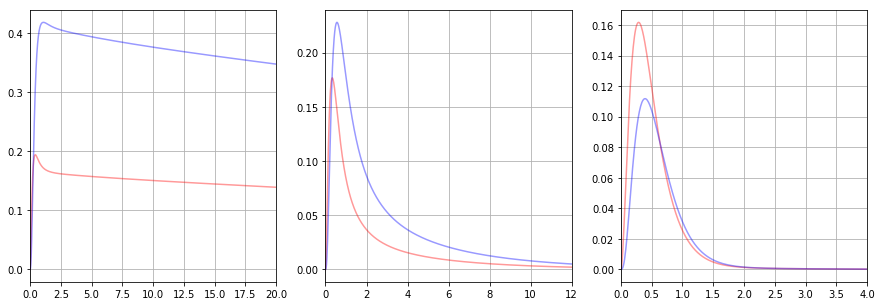

In [10]:
X = []
X.append(X0)

import time
print('start simulation')
start = time.time()
for i in xrange(2000): # 20 days sec since built map corresponds to 0.01 sec
    X.append(model.predict(X[-1]))

print(X[-1])
print('elapsed time: %s sec'% (time.time()-start))

X = np.array(X)
# X = X[:1000, :, :]
fig, ax = plt.subplots(1, 3, figsize=(15,5))
    
t = np.arange(0, X.shape[0])*1.0/100
for i, state0 in enumerate(X0):
    ax[i].plot(t, X[:, i, 2], 'r-', alpha = 0.4) # TIMP
    ax[i].plot(t, X[:, i, 3], 'b-', alpha = 0.4) # TXMP
    ax[i].grid()

ax[0].set_xlim([0, 20])
ax[1].set_xlim([0, 12])
ax[2].set_xlim([0, 4])


plt.show()

The dynamics is the same as described in the article. This is possible to achive since Lie map describes our system in terms of tensor map representation instead of differential equations.